In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.datasets import load_digits
import sys
from sklearn import preprocessing

In [10]:
class Layer:
    weights: np.array
    bias: float
    derivatives: np.array
    input: np.array
    n_perceptrons: int

    def __init__(self, n_perceptrons) -> None:
        self.n_perceptrons = n_perceptrons

    def _update_weights(self, gradient, learning_rate):
        self.weights -= learning_rate * gradient.T.dot(self.input)
        self.bias -= learning_rate * np.sum(gradient, axis=0)

    def get_output(
        self,
        activation_function
    ):
        weighted_sum = self.input.dot(self.weights.T) + self.bias
        output = self._activation_function(weighted_sum, activation_function)

        return output

    def initialize_weights(self):
        n_features = self.input.shape[1]
        self.weights = []

        min = -math.sqrt(6/n_features)
        max = math.sqrt(6/self.n_perceptrons)

        for _ in range(self.n_perceptrons):
            self.weights.append(np.array([np.random.uniform(min, max) for _ in range(n_features)]))

        self.weights = np.array(self.weights)
        self.bias = np.zeros(self.n_perceptrons)

    def set_input(self, input):
        self.input = input

    def get_input(self):
        return self.input

    def get_weights(self):
        return self.weights

    def get_derivatives(self):
        return self.derivatives

    def _activation_function(self, weighted_sums, activation_function):
        if activation_function == 'relu':
            return self._relu(weighted_sums, 0)

        if activation_function == 'l_relu':
            return self._relu(weighted_sums, 0.01)

        if activation_function == 'sigmoid':
            return self._sigmoid(weighted_sums)

        if activation_function == 'tanh':
            return self._tanh(weighted_sums)

        raise ValueError('Invalid Activation Function!')

    def _relu(self, weighted_sum, rate):
        output = np.where(weighted_sum < 0, rate*weighted_sum, weighted_sum)
        self.derivatives = np.where(weighted_sum < 0, rate, 1)

        return output

    def _sigmoid(self, weighted_sum):
        denominator = np.subtract(1, np.power(math.e, weighted_sum))
        output = np.where(denominator == 0, 0, np.divide(1, denominator))
        self.derivatives = np.multiply(output, np.subtract(1, output))

        return output

    def _tanh(self, weighted_sum):
        output = np.tanh(weighted_sum)

        denominator = np.power(np.add(output, 1), 2)
        self.derivatives = np.where(denominator != 0, np.divide(4, denominator), 0)

        return output

    @property
    def get_len(self):
        return self.n_perceptrons

In [11]:
class MLP:
    layers: list
    learning_rate: float
    activation_function: str
    loss: str

    def __init__(self):
        self.layers = list()

    def remove_layer(self, index):
        del self.layers[index]

    def add_layer(self, n_perceptrons):
        self.layers.append(Layer(n_perceptrons))

    def _forward_propagation(
        self,
        features: np.array,
        initialized: int,
    ):
        input = features
        for layer in self.layers:
            layer.set_input(input)

            if initialized == False:
                layer.initialize_weights()

            input = layer.get_output(self.activation_function)

        return input

    def fit(
        self,
        features: np.array,
        labels: np.array,
        learning_rate=0.0001,
        epochs=1000,
        activation_function='relu',
        loss='mse',
        batch_size=None
    ):
        self.learning_rate = learning_rate
        self.activation_function = activation_function
        self.loss = loss

        n_samples = labels.shape[0]
        if batch_size == None:
            batch_size = n_samples

        n_classes = labels.shape[1]

        self.layers.append(Layer(n_classes))

        itt = 0
        initialized = False
        while itt < epochs:
            for m in range(math.ceil(n_samples/batch_size)):
                start = m * batch_size
                end = start + batch_size

                if end >= n_samples:
                    end = n_samples

                outputs = self._forward_propagation(features[start:end], initialized)
                probas = self._softmax(outputs)

                d_loss, loss = self._loss_function(probas, labels[start:end])
                self._back_propagation(d_loss)

            itt += 1
            initialized = True

    def predict(self, features):
        outputs = self._forward_propagation(features, True)

        proba = self._softmax(outputs)
        predictions = np.argmax(outputs, axis=1)

        return predictions

    def _softmax(self, output):
        axis = len(output.shape) - 1
        numerator = np.exp(output)
        denominator = numerator.sum(axis=axis, keepdims=True)

        probabilities = numerator / denominator
        return probabilities

    def _loss_function(self, probas, labels):
        if self.loss == 'mse':
            return self._mse(probas, labels)
        if self.loss == 'gd':
            return np.subtract(probas, labels), np.subtract(probas, labels)
        if self.loss == 'entropy':
            return self._cross_entropy(probas, labels)

    def _cross_entropy(self, probas, labels):
        loss = -labels * np.log(probas)
        errors = np.subtract(probas, labels)
        d_loss = np.divide(errors, errors.shape[0])

        return d_loss, loss

    def _mse(self, probas, labels):
        loss = np.mean(np.square(probas - labels))
        errors = np.subtract(probas, labels)
        d_loss = np.multiply(2, errors) / errors.shape[0]

        return d_loss, loss

    def _back_propagation(self, loss_derivative):
        gradient = loss_derivative

        for layer in self.layers[::-1]:
            actv_derivatives = layer.get_derivatives()
            neuron_gradient = actv_derivatives * gradient
            gradient = neuron_gradient.dot(layer.get_weights())

            layer._update_weights(neuron_gradient, self.learning_rate)

    def _update_label(self, cls, arr):
        return np.where(arr==cls, 1, 0)

# Preparação dos Dados

In [12]:
digits = load_digits()

data = digits.data
label = digits.target

df = {str(x): [] for x in range(64)}
for row in data:
    for index, gs_number in enumerate(row):
        df[str(index)].append(gs_number)
df["target"] = label

df = pd.DataFrame(data=df)
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9


In [13]:
def normalize(arr):
    scaler = preprocessing.Normalizer().fit(arr)
    norm_arr = scaler.transform(arr)

    return norm_arr

def binarize(arr):
    scaler = preprocessing.LabelBinarizer().fit(arr)
    bin_arr = scaler.transform(arr)

    return bin_arr

In [14]:
features = df.drop(columns='target')
labels = df['target']

labels = binarize(np.array(labels))

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=2)

In [15]:
x_train = normalize(np.array(x_train))
x_test = normalize(np.array(x_test))
x_val = normalize(np.array(x_val))

# Treinamento

In [16]:
# melhor resultado: 128 perceptrons, lr = 0.005, epochs = 300, activation = relu, batch = 5

mlp = MLP()
mlp.add_layer(128)
mlp.fit(np.array(x_train), np.array(y_train), 0.005, 300, 'relu', 'mse', batch_size=5)

# Validação

In [17]:
y_pred = mlp.predict(np.array(x_val))
y_true = np.argmax(y_val, axis=1)
np.count_nonzero(y_true - y_pred)

3

# Teste

In [18]:
y_pred = mlp.predict(np.array(x_test))
y_true = np.argmax(y_test, axis=1)
np.count_nonzero(y_true - y_pred)

5

# Avaliação de Desempenho

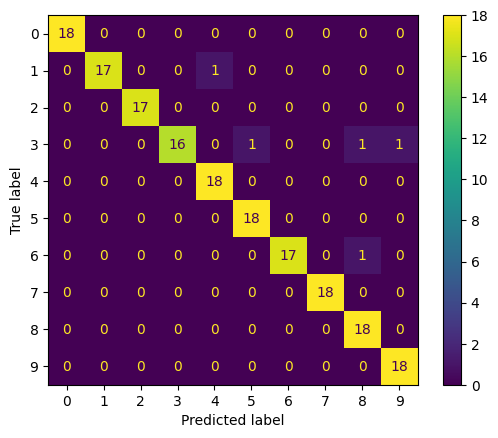

In [19]:
cm = confusion_matrix(y_true, y_pred)
cm = ConfusionMatrixDisplay(cm)

cm.plot()
plt.show()

In [20]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.94      0.97        18
           2       1.00      1.00      1.00        17
           3       1.00      0.84      0.91        19
           4       0.95      1.00      0.97        18
           5       0.95      1.00      0.97        18
           6       1.00      0.94      0.97        18
           7       1.00      1.00      1.00        18
           8       0.90      1.00      0.95        18
           9       0.95      1.00      0.97        18

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180

